# Almost Visual Inertial Odometry

# Imports

In [74]:
import torch
import torch.nn as nn
from collections import OrderedDict
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import *
from torchvision.models.resnet import BasicBlock
from torch.utils.data import DataLoader
from tqdm import tqdm
from  matplotlib import pyplot as plt
from matplotlib.image import imread
import pandas as pd
import numpy as np

# Constants

In [75]:
SEED = 20197
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
GAMMA = 0.1   # torch default
LR=0.001 
EPOCHS = 210
EARLY_STOPPING = 20

In [76]:
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device

In [77]:
available_cuda = torch.cuda.is_available()
print(f"Available cuda: {available_cuda}")

device = torch.device("cuda" if available_cuda else "cpu")

Available cuda: True


# Dataset

In [78]:
class AdvioDataset(torch.utils.data.Dataset):
      def __init__(self, frames, inertials, labels, inertials_buffer, choose_split=None, split={'train':0.6, 'val':0.2, 'test':0.2}, shuffle=True):
            if shuffle:
                  shuffled_index = torch.randperm(frames.shape[0])
                  frames = frames[shuffled_index]
                  inertials = inertials[shuffled_index]
                  labels = labels[shuffled_index]
                  inertials_buffer = inertials_buffer[shuffled_index]
            
            if choose_split is None:
                  self.frames = frames
                  self.inertials = inertials
                  self.labels = labels
                  self.inertials_buffer = inertials_buffer
            else:
                  assert split['train'] + split['val'] + split['test'] == 1
                  length = frames.shape[0]
                  if choose_split == "train":
                        self.frames = frames[:round(split['train']*length)]
                        self.inertials = inertials[:round(split['train']*length)]
                        self.labels = labels[:round(split['train']*length)]
                        self.inertials_buffer = inertials_buffer[:round(split['train']*length)]
                  elif choose_split == "val":
                        self.frames = frames[round(split['train']*length):-round(split['test']*length)]
                        self.inertials = inertials[round(split['train']*length):-round(split['test']*length)]
                        self.labels = labels[round(split['train']*length):-round(split['test']*length)]
                        self.inertials_buffer = inertials_buffer[round(split['train']*length):-round(split['test']*length)]
                  elif choose_split == "test":
                        self.frames = frames[-round(split['test']*length):]
                        self.inertials = inertials[-round(split['test']*length):]
                        self.labels = labels[-round(split['test']*length):]
                        self.inertials_buffer = inertials_buffer[-round(split['test']*length):]
                  else:
                        raise Exception(f"The split name '{choose_split}' doesn't exists")

      def __len__(self):
            return len(self.frames) - 1

      def __getitem__(self, index):
            # load sample of frames
            frame_name = self.frames[index]
            scene_name, frame_name = frame_name.split("_")
            frame_name, file_extension = frame_name.split(".")
            sample_frame = torch.Tensor(np.load(f"./data/{scene_name}/iphone/frames/{scene_name}_{frame_name}.npy", allow_pickle=True))

            # build buffer sample of inertials
            sample_inertials_buffer = self.inertials_buffer[index]

            # load labels
            label_odometry = self.labels[index]

            # load inertials
            label_inertial = self.inertials[index]

            return sample_frame, sample_inertials_buffer, label_odometry, label_inertial


frames = np.load("dataset_frames.npy", allow_pickle=True)
inertials = torch.Tensor(np.load("dataset_inertials.npy", allow_pickle=True))
labels = torch.Tensor(np.load("dataset_labels.npy", allow_pickle=True))
buffer_inertials = torch.Tensor(np.load("dataset_buffer.npy", allow_pickle=True))

train_data = AdvioDataset(frames, inertials, labels, buffer_inertials, "train")
val_data = AdvioDataset(frames, inertials, labels, buffer_inertials, "val")
test_data = AdvioDataset(frames, inertials, labels, buffer_inertials, "test")

del frames
del inertials
del labels
del buffer_inertials

params = {'batch_size': BATCH_SIZE,
          'num_workers': 6,
          'drop_last':True}

train_loader = DataLoader(train_data, **params, shuffle=True)
val_loader = DataLoader(val_data, **params, shuffle=True)
test_loader = DataLoader(test_data, **params)

# Model

In [79]:
def replace_head(model):
    n_inputs = model.classifier[0].in_features
    classifier = nn.Linear(n_inputs, 100)
    model.classifier[0] = classifier

    n_inputs = model.classifier[3].in_features
    classifier = nn.Linear(100, 3)
    model.classifier[3] = classifier
    return model

In [80]:
class BaselineNet2(nn.Module):
    def __init__(self):
        super(BaselineNet2, self).__init__()
        
        self.conv2d_odometry = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        self.conv2d_odometry = replace_head(self.conv2d_odometry)

    def forward(self, x):
        x = self.conv2d_odometry(x)
        return x

In [81]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        
        self.conv2d_odometry = MobileNetV2(num_classes=3)

    def forward(self, x):
        x = self.conv2d_odometry(x)
        return x

# Training

In [82]:
def normalize(data):
  data = data - data.min()
  data = data / data.max()
  return data

In [83]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    history_loss = 0

    for batch_idx, (data, _, labels_odometry, _) in enumerate(train_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        data, labels_odometry = data.to(device), labels_odometry.to(device)

        #forward
        optimizer.zero_grad()
        output = model(data)

        # loss
        loss = torch.sqrt(F.mse_loss(output, labels_odometry))

        # backward
        loss.backward()
        optimizer.step()

        #stats
        history_loss += loss.item()

        if batch_idx%(len(train_loader)//5)==0:
            print(f"\t[# {batch_idx: 4}] train_loss: {loss.item():.6f}")

    history_loss /= len(train_loader) # average epoch loss
    print(f"\ttrain_loss: {history_loss:.6f}")

    return history_loss


In [84]:
def validation(model, device, val_loader, epoch):
    model.train()
    history_loss=0

    for batch_idx, (data, _, labels_odometry, _) in enumerate(val_loader):
        # data preparation
        data = normalize(data)
        labels_odometry = labels_odometry.mean(axis=1)
        data, labels_odometry = data.to(device), labels_odometry.to(device)

        # forward
        output = model(data)

        # loss
        loss = torch.sqrt(F.mse_loss(output, labels_odometry))

        #stats
        history_loss += loss.item()

    history_loss /= len(val_loader) # average epoch loss
    print(f"\tval_loss: {history_loss:.6f}")

    return history_loss


In [85]:
model = BaselineNet2().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

h_loss_train = []
h_loss_val = []

early_stopping = {"epoch":0, "best":10**3, "epoch_threshold":EARLY_STOPPING}

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")

    loss_train = train(model, device, train_loader, optimizer, epoch)
    loss_val = validation(model, device, val_loader, epoch)

    #populating the history of the loss
    h_loss_train.append(loss_train)
    h_loss_val.append(loss_val)

    # early stopping
    if loss_val < early_stopping["best"]:
        early_stopping["best"] = loss_val
        early_stopping["epoch"] = epoch
        print("\t*** Personal Best ***")

    if epoch - early_stopping["epoch"] > early_stopping["epoch_threshold"]:
        print("\n\tStopped by  early stopping!")
        break

np.savez(f"train_loss_{EPOCHS}", h_loss_train)
np.savez(f"val_loss_{EPOCHS}", h_loss_val)


Epoch 1/210
	[#    0] train_loss: 17.918837
	[#  180] train_loss: 11.736006
	[#  360] train_loss: 10.976809
	[#  540] train_loss: 6.604259
	[#  720] train_loss: 9.857423
	[#  900] train_loss: 8.324232
	train_loss: 11.029631
	val_loss: 7.096916
	*** Personal Best ***
Epoch 2/210
	[#    0] train_loss: 8.886558
	[#  180] train_loss: 7.993495
	[#  360] train_loss: 5.226495
	[#  540] train_loss: 13.042361
	[#  720] train_loss: 6.399005
	[#  900] train_loss: 4.881711
	train_loss: 6.211379
	val_loss: 4.818977
	*** Personal Best ***
Epoch 3/210
	[#    0] train_loss: 4.510308
	[#  180] train_loss: 4.349883
	[#  360] train_loss: 3.946164
	[#  540] train_loss: 3.972699
	[#  720] train_loss: 4.854510
	[#  900] train_loss: 4.204525
	train_loss: 4.392783
	val_loss: 4.337262
	*** Personal Best ***
Epoch 4/210
	[#    0] train_loss: 3.894087
	[#  180] train_loss: 5.166529
	[#  360] train_loss: 4.684035
	[#  540] train_loss: 5.451829
	[#  720] train_loss: 3.817747
	[#  900] train_loss: 3.438318
	train_l

# Plotting

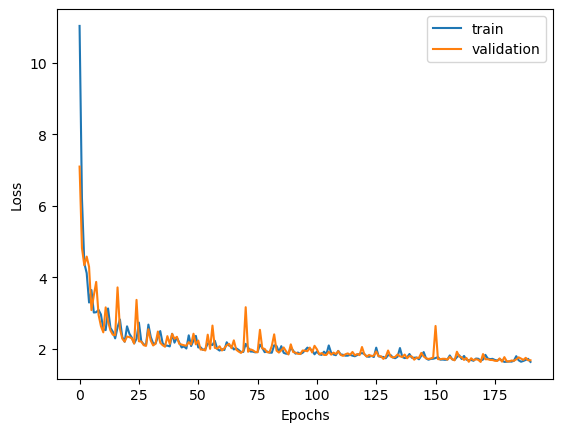

In [86]:
plt.plot(h_loss_train, label="train")
plt.plot(h_loss_val, label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

### Zoomed plot (last 30 epochs)

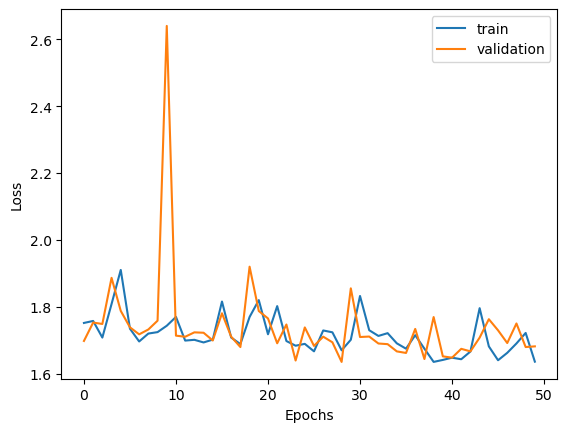

In [90]:
plt.plot(np.array(h_loss_train)[-50:], label="train")
plt.plot(np.array(h_loss_val)[-50:], label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()